In [1]:
import sys
import serial 
import time
import math
import requests
import serial.tools.list_ports

In [2]:
ports = serial.tools.list_ports.comports()
serialInst = serial.Serial()
portsList = []
for onePort in ports:
    portsList.append(str(onePort))
    print(str(onePort))


/dev/cu.BLTH - n/a
/dev/cu.JIBTRUE2 - n/a
/dev/cu.AltecLansingFury - n/a
/dev/cu.Bluetooth-Incoming-Port - n/a
/dev/cu.usbserial-1430 - USB2.0-Ser!


In [3]:
# Now open the serial port
port = portsList[-1].split(' ')[0]
print("Opening port: " + port)
ser = serial.Serial(port, 9600, timeout=1)
ser.flush()

Opening port: /dev/cu.usbserial-1430


In [4]:
data = []
last_lat = None
last_lon = None

In [5]:
def calculate_bearing(lat1, lon1, lat2, lon2):
    dLon = math.radians(lon2 - lon1)
    lat1 = math.radians(lat1)
    lat2 = math.radians(lat2)

    x = math.sin(dLon) * math.cos(lat2)
    y = math.cos(lat1) * math.sin(lat2) - math.sin(lat1) * math.cos(lat2) * math.cos(dLon)

    bearing = math.atan2(x, y)
    bearing = math.degrees(bearing)
    return (bearing + 360) % 360

def infer_direction(bearing):
    if 45 <= bearing <= 135:
        return 'right'
    elif 135 < bearing <= 225:
        return 'backward'
    elif 225 < bearing <= 315:
        return 'left'
    else:
        return 'forward'

In [6]:
def convert_to_decimal_degrees(raw_coord, direction):
    degrees = int(float(raw_coord) / 100)
    minutes = float(raw_coord) - degrees * 100
    decimal_degrees = degrees + minutes / 60
    if direction in ['S', 'W']:
        decimal_degrees = -decimal_degrees
    return decimal_degrees

In [7]:
def parse_gps_data(gps):
    # Helper function to convert N/S and E/W to decimal degrees
    def convert_to_decimal_degrees(degree_str, direction):
        degrees = float(degree_str[:2]) + float(degree_str[2:]) / 60.0
        if direction in ['S', 'W']:
            degrees = -degrees
        return degrees

    # Extract latitude and longitude with correct indices
    lat = convert_to_decimal_degrees(gps[3], gps[4])
    lon = convert_to_decimal_degrees(gps[5], gps[6])

    # Create return dictionary with available data
    result = {
        "latitude": lat,
        "longitude": lon,
        "speed": float(gps[7]) * 1.852 if len(gps) > 7 else 0,  # Convert knots to km/h
        "datetime": gps[1] if len(gps) > 1 else ""
    }
    
    try:
        global last_lat, last_lon
        if last_lat is not None and last_lon is not None:
            bearing = calculate_bearing(last_lat, last_lon, lat, lon)
            result["bearing"] = bearing
            result["direction"] = infer_direction(bearing)
    except Exception as e:
        print(f"Error calculating bearing or direction: {e}")

    last_lat = lat
    last_lon = lon

    return result

TOF=-1.0 HC=0.0 GPS=(['$GPRMC', '083622.00', 'A', '3358.83440', 'N', '07125.64415', 'E', '0.056'])



In [8]:
def send_data_to_server(tof, hc, gpsdata):
    payload = {
        "uid": "bilal",
        "timeOfFlight": tof,
        "hc": hc,
        **gpsdata
    }
    data.append(payload)
    return payload
    # print(payload)
    # print("Payload to send:", payload)
    # try:
    #     response = requests.post("http://159.223.192.36:3333/save-location", json=payload)
    #     if response.status_code == 200:
    #         print("Data sent to remote server.")
    #     else:
    #         print(f"Server error {response.status_code}: {response.text}")
    # except Exception as e:
    #     print("Error sending to server:", e)
    
# send_data_to_server("2.90","1.80",parse_gps_data(['$GPRMC', '083622.00', 'A', '3358.83440', 'N', '07125.64415', 'E', '0.056']))


TOF=-1.0 HC=0.0 GPS=(['$GPRMC', '083622.00', 'A', '3358.83440', 'N', '07125.64415', 'E', '0.056'])



In [9]:
while True:
    if ser.in_waiting > 0:
        line = ser.readline().decode('utf-8', errors='ignore').strip()
        print(line)
        try:
            splitedData = line.split(',')

            tof = float(splitedData[0])
            hc = float(splitedData[1])
            gps = splitedData[2:10]

            lat = convert_to_decimal_degrees(gps[3], gps[4])
            lon = convert_to_decimal_degrees(gps[5], gps[6])
            
            gpsdata = parse_gps_data(gps)

            finldata= send_data_to_server(tof, hc, gpsdata)
            
            # print(finldata)

        except Exception as e:
            print("Parsing error:", e)

    time.sleep(1)




KeyboardInterrupt: 

In [12]:
len(data)

237

In [10]:
import pandas as pd
df = pd.DataFrame(data)

In [11]:
df.to_csv('uni7_data.csv', index=False)

In [18]:
import folium

# Create a map centered at the mean latitude and longitude
map_center = [df['latitude'].mean(), df['longitude'].mean()]
mymap = folium.Map(location=map_center, zoom_start=15)

# Add markers for each row in the dataframe
for _, row in df.iterrows():
    folium.Marker(
        location=[row['latitude'], row['longitude']],
        popup=f"UID: {row['uid']}<br>Speed: {row['speed']} km/h<br>Direction: {row['direction']}",
    ).add_to(mymap)

# Display the map
mymap

In [20]:
from folium import Map, PolyLine, Marker
from folium.plugins import MarkerCluster
from folium.utilities import validate_location


# Create a map with bounds adjusted to the coordinates
bounds = [[min(df['latitude']), min(df['longitude'])], [max(df['latitude']), max(df['longitude'])]]
zoomed_map = Map(location=map_center, zoom_start=15)
zoomed_map.fit_bounds(bounds)

# Define coordinates as a list of latitude and longitude pairs
coordinates = df[['latitude', 'longitude']].values.tolist()

# Add a PolyLine to represent the continuous movement
PolyLine(
    locations=coordinates,
    color='blue',
    weight=3,
    opacity=0.8
).add_to(zoomed_map)

# Add clustered markers for each point
marker_cluster = MarkerCluster().add_to(zoomed_map)
for _, row in df.iterrows():
    Marker(
        location=[row['latitude'], row['longitude']],
        popup=f"UID: {row['uid']}<br>Speed: {row['speed']} km/h<br>Direction: {row['direction']}",
    ).add_to(marker_cluster)

# Display the map
zoomed_map



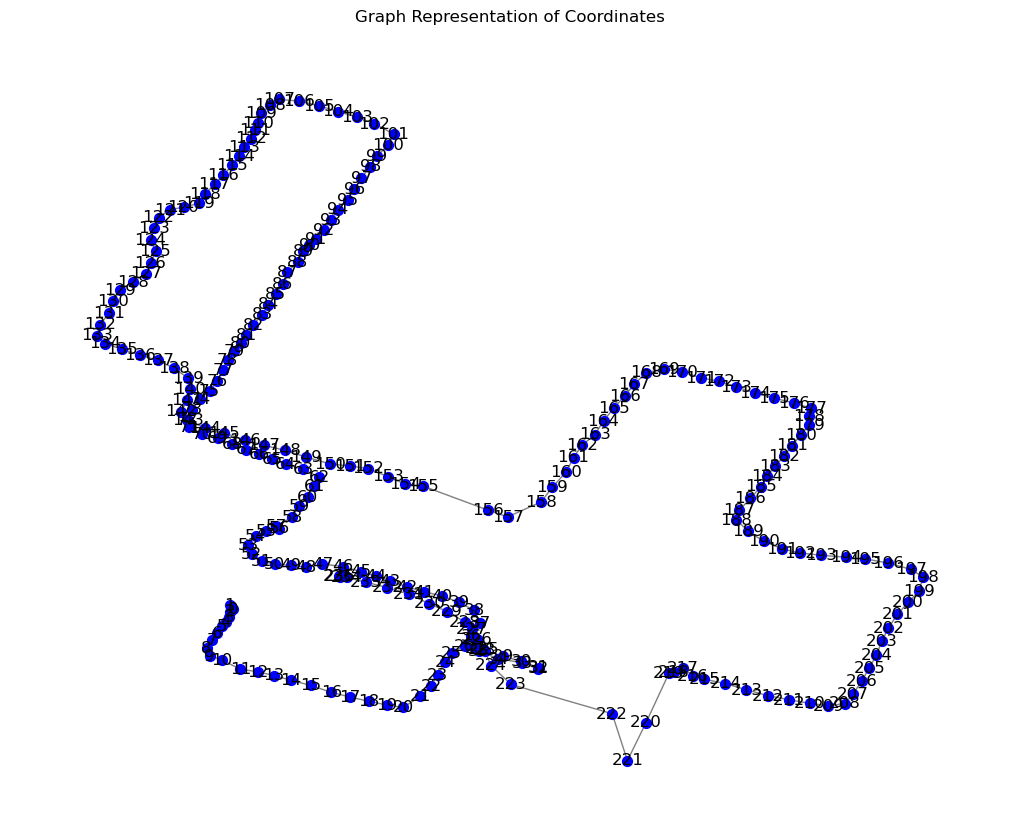

In [ ]:
import networkx as nx

import matplotlib.pyplot as plt

G = nx.Graph()

for i, coord in enumerate(coordinates):
    G.add_node(i, pos=coord)
    if i > 0:
        G.add_edge(i - 1, i)

# Get positions for nodes
pos = nx.get_node_attributes(G, 'pos')

# Draw the graph
plt.figure(figsize=(10, 8))
nx.draw(G, pos, with_labels=True, node_size=50, node_color='blue', edge_color='gray')
plt.title("Graph Representation of Coordinates")
plt.show()

In [ ]:
# try:
#         tof, hc, lat, lon = line.split(',')
#         tof = int(tof)
#         hc = int(hc)
#         lat = float(lat)
#             lon = float(lon)
#             print(f"TOF={tof} HC={hc} GPS=({lat},{lon}) Bearing={bearing:.2f}° Direction={direction}")


#             if last_lat is not None and last_lon is not None:
#                 bearing = calculate_bearing(last_lat, last_lon, lat, lon)
#                 direction = infer_direction(bearing)
#             else:
#                 bearing = 0
#                 direction = 'start'

#             send_data_to_server(tof, hc, lat, lon, bearing, direction)
#             print(f"TOF={tof} HC={hc} GPS=({lat},{lon}) Bearing={bearing:.2f}° Direction={direction}")

#             last_lat = lat
#             last_lon = lon

#         except Exception as e:
#             print("Parsing error:", e)